In [281]:
from padercontrib.database.fearless import Fearless
import padertorch as pt
import paderbox as pb
import numpy as np
import paderbox as pb
from padercontrib.database.iterator import AudioReader
from paderbox.transform import stft,fbank
import scipy
import torch.nn as nn
import pydub
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import pandas as pd
from pydub import AudioSegment
import torch
from functools import partial
import lazy_dataset
from padertorch.data.utils import collate_fn
import json,pickle
from loss_functions2 import AngularPenaltySMLoss2
from torch.nn.utils.rnn import pad_sequence

In [282]:
db = Fearless()
ds = db.get_dataset('Train_segment')
lb = LabelEncoder()
dev = torch.device("cuda")

In [22]:
train_167 = pb.io.load_json("/net/home/dheerajpr/my_project/fearless/fearless/sid/train_167.json")
train_167_lazy = lazy_dataset.new(train_167['Train_167'])
dev_167 = pb.io.load_json("/net/home/dheerajpr/my_project/fearless/fearless/sid/dev_167.json")
dev_167_lazy = lazy_dataset.new(dev_167['Dev_167'])

In [12]:
def prep_example(example):
    audio = pb.io.load_audio(example['audio_path']['observation'])
    example['array_samples'] = audio
    return example

In [13]:
new_dev = []
new_train = []
for i in dev_167_lazy:
    new_dev.append(prep_example(i))
for j in train_167_lazy:
    new_train.append(prep_example(j))

KeyboardInterrupt: 

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame(dev_167['Dev_167'])
df_grt = df[df['num_samples']>=32000]
df_low =  df[df['num_samples']<32000]

In [19]:
len(set(df['speaker_id']))

167

In [ ]:
segmenter = pt.data.segment.Segmenter(length=32000,include_keys='array_samples',padding=True,copy_keys=True,
                                      mode='constant')
segmented_train = []



In [ ]:
df_grt_dict = pd.DataFrame.to_dict(df_grt,'records')
df_low_dict = pd.DataFrame.to_dict(df_low,'records')
len(df_low_dict)


In [ ]:
for i in df_grt_dict:
    segmented_train.append(segmenter(i))

In [ ]:
segmented_train_unbatch = []

for i in segmented_train:
    for j in i:
        segmented_train_unbatch.append(j)

In [ ]:
segmented_train_unbatch = [{k: v for k, v in d.items() if k != 'segment_start'} for d in segmented_train_unbatch]
segmented_train_unbatch = [{k: v for k, v in d.items() if k != 'segment_stop'} for d in segmented_train_unbatch]

In [ ]:
len(segmented_train_unbatch[-2])

In [ ]:
final_train_list = []

for i in df_low_dict:
    final_train_list.append(i)


In [ ]:
len(df_low_dict)

In [ ]:
for j in segmented_train_unbatch:
    final_train_list.append(j)

In [ ]:
len(final_train_list)

In [ ]:
for i in final_train_list:
    if i['num_samples']<32000:
        j = 32000 - i['num_samples']
        i['array_samples'] = np.concatenate((i['array_samples'],np.zeros(j)))

In [ ]:
len(final_train_list)

In [ ]:
trainlist_final = sorted(final_train_list, key=lambda k: k['audio_path']['observation'])

In [ ]:
for i in trainlist_final:
    i['array_samples'] = np.float32(i['array_samples'])

In [ ]:
train_167_seg = {'Train_167':trainlist_final}

In [ ]:
train_167_seg

In [ ]:
def prepare_data(example):
    
    def prep_data(example):
        audio = pb.io.load_audio(example['audio_path']['observation'],dtype=np.float32)
        example['array_samples'] = audio
        
        if len(audio)<32000:
            j = 32000-len(audio)            
            audio = np.concatenate((audio,np.zeros(j)))
            example['array_samples'] = audio
        
        elif len(audio)>=32000:
            segmenter = pt.data.segment.Segmenter(length=32000,include_keys='array_samples',padding=True,copy_keys=True,
                                      mode='constant')
            segmented = segmenter(example)
            
            example['array_samples'] = segmented[0]['array_samples']
            
        return example
    
    return example.map(prep_data)

In [ ]:
def segmented(example):
    
    seg_unbatch = []
    ds = example
    for j in ds:
        
        audio = pb.io.load_audio(j['audio_path']['observation'],dtype=np.int16)
        j['array_samples'] = audio
        seg = []
        if len(audio)>=32000:
            
            segmenter = pt.data.segment.Segmenter(length=32000,include_keys='array_samples',padding=True,
                                      mode='constant')
            seg.append(segmenter(j))
            
        for i in seg:
            for j in i:
                seg_unbatch.append(j)
                
    seg_unbatch = [{k: v for k, v in d.items() if k != 'segment_start'} for d in seg_unbatch]
    seg_unbatch = [{k: v for k, v in d.items() if k != 'segment_stop'} for d in seg_unbatch] 
    
    for o in ds:
        audio = pb.io.load_audio(o['audio_path']['observation'],dtype=np.int16)
        if len(audio)<32000:
            p = 32000-len(audio)            
            audio = np.concatenate((audio,np.zeros(p)))
            o['array_samples'] = audio
            
            seg_unbatch.append(o)
    
    seg_unbatch = sorted(seg_unbatch, key=lambda k: k['audio_path']['observation'])
    
    return(seg_unbatch)




In [285]:
train_sid = db.get_dataset("Train_SID")
dev_sid = db.get_dataset("Dev_SID")

In [ ]:
sg_dev_sid = segmented(dev_sid)

In [ ]:
sg_dev_sid = lazy_dataset.new(sg_dev_sid)

In [ ]:
sg_dev = segmented(dev_167['Dev_167'])
sg_train = segmented(train_167['Train_167'])

In [287]:
len(train_sid)

27336

In [ ]:
sg_dev_lazy = lazy_dataset.new(sg_dev)

sg_train_lazy = lazy_dataset.new(sg_train)

In [283]:
def prepare_data_4(example, batch_size, shuffle = False):

    ds = example
    
    def prep_features(example):
        
        fbank_data = []
        audio = example['array_samples']
        
        """ Compute the 64 dimensional filter banks for the 4secs fixed length audio segments"""
    
        fbank = pb.transform.fbank(audio, sample_rate=8000, window_length=400, stft_shift=160,number_of_filters=64,
                        stft_size=512,lowest_frequency=0,highest_frequency=None, preemphasis_factor=0.97, 
                        window=scipy.signal.windows.hamming)
        fbank_data.append(fbank)
        tens_fbank = torch.FloatTensor(fbank_data)

        example['features'] = (tens_fbank)
        
        return example
    
    def prep_label(example):

        label_dict_hot = pb.io.load_json(path = '/net/home/dheerajpr/my_project/fearless/fearless/sid/labels_sid_hot.json')
        label_dict3 = pb.io.load_json(path = '/net/home/dheerajpr/my_project/fearless/fearless/sid/labels_sid.json')

        if example['speaker_id'] in label_dict_hot.keys():
        
            pos = label_dict_hot[example['speaker_id']]
            example['label_hot'] = np.array(pos)
        
    
        if example['speaker_id'] in label_dict3.keys():
        
            pos = label_dict3[example['speaker_id']]
            example['label_array'] = np.array(pos)
        return example
        
    
    def stack(example):
        example['features'] = np.stack(example['features'])
        example['label_hot'] = np.stack(example['label_hot'])
        example['label_array'] = np.stack(example['label_array'])
        
        
        return example
    
    example = (example
               .map(prep_features)
               .map(prep_label)
               .batch(batch_size).map(collate_fn)
               .map(stack))
               #.prefetch(buffer_size=8, num_workers=8))
            
            
    return example

In [284]:
a = prepare_data_4(sg_dev_sid,10)
a[0]

NameError: name 'sg_dev_sid' is not defined

In [ ]:
from fearless.sid.model_resnet_SID import ResNet_SID

In [ ]:
model = ResNet_SID()

In [ ]:
import sklearn
from sklearn import metrics
    
trainer = pt.train.trainer.InteractiveTrainer(
                model.to('cuda'),
                optimizer=pt.train.optimizer.SGD(lr=0.1),#,nesterov=True,momentum=0.9),
            
                stop_trigger=(10,'epoch'),
                summary_trigger=(1,'iteration'),
            
                )
#trainer.register_hook(pt.train.hooks.LRSchedulerHook(
#torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer.optimizer, gamma=0.1))) #, milestones=[25,40]))
trainer.train(a[0:1])

In [56]:
import pandas as pd
label_dict = pb.io.load_json(path = '/net/home/dheerajpr/my_project/fearless/fearless/sid/labels_167.json')

In [57]:
label_dict.

{'AFD1': 0,
 'AFD3': 1,
 'AFD5': 2,
 'AGC': 3,
 'ALDS': 4,
 'ALSEP': 5,
 'ANTIGUA': 6,
 'ARIA': 7,
 'ASCENSION': 8,
 'ASCENSIONCOMMTECH': 9,
 'BERMUDA': 10,
 'BOOSTER1': 11,
 'BUZZ': 12,
 'CALIFORNIA': 13,
 'CANARY': 14,
 'CAPCOM1': 15,
 'CAPCOM2': 16,
 'CARNARVON': 17,
 'CCATSCOMMAND': 18,
 'CCATSTELEMETRY': 19,
 'CLTC': 20,
 'COLLINS': 21,
 'COMM': 22,
 'COMMANAGER1': 23,
 'COMMANAGER3': 24,
 'COMMCONTROL1': 25,
 'COMMCONTROL2': 26,
 'COMMCONTROL3': 27,
 'COMMCONTROL4': 28,
 'COMPUTERMNO': 29,
 'COMPUTERTM': 30,
 'CONSUMABLES': 31,
 'CONTROL1': 32,
 'CONTROL2': 33,
 'CPSPK': 34,
 'CPSS': 35,
 'CTSC': 36,
 'CVTS': 37,
 'DATACORE': 38,
 'DEPUTYLOM': 39,
 'DISPLAY': 40,
 'ECS1': 41,
 'ECS2': 42,
 'EECOM1': 43,
 'EECOM2': 44,
 'EECOM3': 45,
 'EECOM5': 46,
 'EMU': 47,
 'EPE': 48,
 'EPS2': 49,
 'EPS3': 50,
 'EVA': 51,
 'EXPERIMENTS': 52,
 'FAO1': 53,
 'FAO2': 54,
 'FAO3': 55,
 'FD1': 56,
 'FD2': 57,
 'FD3': 58,
 'FEMALE2': 59,
 'FIDO1': 60,
 'FIDO3': 61,
 'FORTYEIGHT': 62,
 'GBM': 63,
 'GC

In [177]:
df = pd.DataFrame(train_167['Train_167'])

df1 = df.sort_values(by=['speaker_id'])

spk_train = []

for i in df['speaker_id']:
    if i in label_dict.keys():
        spk_train.append(i)


In [178]:
unique, counts = np.unique(spk_train, return_counts=True)
dict1 = dict(zip(unique, counts))

In [183]:
dict_new = dict(sorted(dict1.items(), key=lambda item:item[1]))


In [227]:
dict_50 = []
for i in dict_new.items():
    if i[1]<50:
        dict_50.append(i[0])

df1['speaker_id']

2282      AFD1
25358     AFD1
13695     AFD1
16309     AFD1
18725     AFD1
         ...  
19914    VOICE
32979    VOICE
754      VOICE
28953    VOICE
31787    VOICE
Name: speaker_id, Length: 33345, dtype: object

In [243]:
df_50 = df[df['speaker_id'].isin(dict_50)]

df_50_dict = pd.DataFrame.to_dict(df_50,'records')

In [260]:
import nlpaug.augmenter.audio as naa
import librosa
import librosa.display as librosa_display
import matplotlib.pyplot as plt

In [258]:
data = pb.io.load_audio(df_50_dict[0]['audio_path']['observation'])

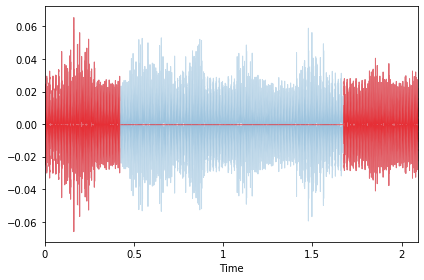

In [280]:
sr=8000

aug = naa.MaskAug(sampling_rate=sr, mask_with_noise=False)
augmented_data = aug.augment(data)

librosa_display.waveplot(data, sr=sr, alpha=0.25)
librosa_display.waveplot(augmented_data, sr=sr, color='r', alpha=0.5)

plt.tight_layout()
plt.show()

In [279]:
 augmented_data == data

array([ True,  True,  True, ...,  True,  True,  True])

In [247]:
def balance_datasets(dataset, balance_factor):
    """
    examples in each event of the dataset is repeated to surpass balance_factor * event with the max number of examples
    input dataset must be of type lazy_dataset
    returns both the original dataset and the extended one(repeated one)
    """
    
    data1 = lazy_dataset.new(dataset)
    new_dataset_dict_orig = copy.deepcopy(data1)
    for key in new_dataset_dict_orig:
        new_dataset_dict_orig[key]['example_id'] = key
        new_dataset_dict_orig[key]['mode'] = 'orig'

    ds_orig = lazy_dataset.new(new_dataset_dict_orig)
    #ds_orig = dataset

    data = {(data1[key])['speaker_id'][0] : 0 for key in data1.keys()}
    """
    Calculate how many examples are there in each event
    """
    for key in data1:
        event = data1[key]['speaker_id'][0]
        data[event] = data[event] + 1

    maximum = (max(data.items(), key=operator.itemgetter(1))[1])
    """
    Calculate how many times examples in each event have to repeated
    """
    repetitions = {(key if value != maximum else key): (
        (int)(balance_factor * (maximum / value)) if (int)(balance_factor * (maximum / value)) != 0 else 1) for
        key, value in data.items()}
    """
    Repeat the examples and concatenate everything in ds(a new dataset)
    """
    new_dataset_ls = []
    for i in repetitions:
        new_dataset_dict = {}
        # new_dataset_dict = {key: value for key, value in data1.items() if value['events'][0] == sound_events}
        for key in data1:
            if data1[key]['speaker_id'][0] == i:
                new_dataset_dict.update({key: data1[key]})
                new_dataset_dict[key]['mode'] = 'ext'
        new_dataset_ls.extend(repetitions[i] * [lazy_dataset.new(new_dataset_dict)])
    ds = lazy_dataset.concatenate(*new_dataset_ls)

    return ds, ds_orig, repetitions

In [251]:
import copy
import operator
new = balance_datasets(df_50_dict,0.1)

NotImplementedError: __getitem__ is not implemented for <class 'lazy_dataset.core.MapDataset'>[{'audio_path': {'observation': '/net/db/fearless/Audio/Segments/ASR_track2/Train/FS02_ASR_track2_train_00002.wav'}, 'dataset': 'Train_segment', 'example_id': 'FS02_train_00002', 'num_samples': 16720, 'speaker_id': 'CONTROL2', 'transcription': 'OKAY WERE CLEAN UH ON [unk]'}],
where type({'audio_path': {'observation': '/net/db/fearless/Audio/Segments/ASR_track2/Train/FS02_ASR_track2_train_00002.wav'}, 'dataset': 'Train_segment', 'example_id': 'FS02_train_00002', 'num_samples': 16720, 'speaker_id': 'CONTROL2', 'transcription': 'OKAY WERE CLEAN UH ON [unk]'}) == <class 'dict'>
self:
  ListDataset(len=1422)
MapDataset(_pickle.loads)

In [172]:
len(new[0]),len(new[1])

(69797, 35473)

In [173]:
new[2]

{'N': 1,
 'C': 1,
 'G': 1,
 'U': 3,
 'P': 3,
 'B': 2,
 'F': 1,
 'R': 3,
 'I': 21,
 'L': 110,
 'S': 5,
 'E': 1,
 'H': 3,
 'T': 1,
 'M': 1,
 'A': 4,
 'O': 24,
 'V': 67,
 'J': 81,
 'D': 53}

In [166]:
df = pd.DataFrame(new[0])

df1 = df.sort_values(by=['speaker_id'])

spk_train = []

for i in df1['speaker_id']:
    if i in label_dict.keys():
        spk_train.append(i)


In [169]:
pb.io.dump_json(new[0],path='train_167_new.json')

TypeError: Object of type ConcatenateDataset is not JSON serializable

In [167]:
unique, counts = np.unique(spk_train, return_counts=True)
dict1 = dict(zip(unique, counts))
dict_new = dict(sorted(dict1.items(), key=lambda item:item[1]))
dict_new

{'CALIFORNIA': 1,
 'COMPUTERTM': 1,
 'GBM': 1,
 'GUAYMAS': 1,
 'MIKE': 1,
 'GUAM': 2,
 'COMMANAGER3': 3,
 'FORTYEIGHT': 3,
 'GMIL': 3,
 'HUNTSVILLE': 3,
 'COMPUTERMNO': 4,
 'CPSS': 4,
 'EPE': 4,
 'NETWORK9': 4,
 'SPS': 5,
 'MSTC2': 6,
 'MEPS': 7,
 'NIXON': 10,
 'CTSC': 12,
 'FEMALE2': 12,
 'GOLDSTONEVIDEO': 13,
 'GCC': 14,
 'SEQUENCER': 15,
 'NETWORK4': 16,
 'COMMCONTROL4': 17,
 'TEXAS': 17,
 'SCS': 20,
 'MCCFILEspk6': 22,
 'CLTC': 23,
 'COMM': 23,
 'CONTROL2': 23,
 'RSO': 24,
 'ALDS': 28,
 'MCCFILEspk4': 28,
 'TANANARIVE': 28,
 'CONSUMABLES': 29,
 'TIC5': 29,
 'TRACK1': 30,
 'GODDARDOPS': 31,
 'CCATSCOMMAND': 32,
 'CPSPK': 32,
 'GOLDSTONECOMMTECH': 33,
 'ANTIGUA': 36,
 'EECOM5': 36,
 'PROCEDURES3': 36,
 'TRACK6': 37,
 'GODDARDVOICE': 43,
 'STONY': 45,
 'COMMCONTROL2': 46,
 'MCCFILEspk3': 46,
 'BERMUDA': 48,
 'MECS': 50,
 'SPAN3': 50,
 'MCCFILEspk5': 52,
 'PLSSCOMM': 54,
 'MLSC': 55,
 'FAO3': 56,
 'COMMCONTROL1': 59,
 'ECS2': 60,
 'EVA': 62,
 'RTC2': 63,
 'CANARY': 68,
 'AGC': 72,
 'AR